In [2]:
# The code was removed by Watson Studio for sharing.

# Coursera Capstone Project

**Jacob Bills**  
Data Systems Engineer

# Objective <a name='objective' />
<p>To determine the best type of business to open based on data among the most popular venues between two of the largest cities in West Virginia</p>

# Background <a name='background' />
<p>Huntington and Charelston WV are the two most populated cities in West Virginia <a href='http://www.togetherweteach.com/TWTIC/uscityinfo/48wv/wvpopr/48wvpr.htm'>(source)</a>. I will use a publicy available list of zip codes in WV to lookup location data using the Google Cloud Platforms Geocoder API. Then I will use Foursquare API to lookup popular venues for each location. I will use this data to evaluate and train multiple clustering models which will help you decide which city is best suited for your business type.</p>

# In this document
* <a href="#objective">Objective</a>
* <a href="#background">Background</a>
* <a href="#datacollection">Data Collection</a>
  * <a href="#datacollectionzipcode">WV zip code data</a>
  * <a href="#datacollectionlocation">Huntington and Charleston location data</a>
  * <a href="#datacollectionvenue">Huntington and Charleston venue data</a>
* <a href="#datasummary">Summary of Data Collection</a>
  * <a href="#datasummaryviz">Data visualization</a>
  * <a href="#datasummaryhuntington">Most popular Huntington venues</a>
  * <a href="#datasummarycharleston">Most popular Charleston venues</a>
* <a href="#datamodeling">Data Modeling</a>
  * <a href="#datamodelingeval">Model evaluation</a>
  * <a href="#datamodelingsel">Evaluation results</a>

# Data Collection <a name='datacollection' />

### Get zip code data for West Virginia <a name='datacollectionzipcode' />
<p>I found this <a href='https://www.zipcodestogo.com/West%20Virginia/'>web site</a> after googling for West Virginia zip codes. I transformed the table and dropped the Zip Code Map column, added latitude column, and added longitude column</p>

In [15]:
import pandas as pd
import numpy as np
wvdata = pd.read_html('https://www.zipcodestogo.com/West%20Virginia/')
wvdata[1].iloc[1:].iloc[0]
headers= wvdata[1].iloc[1:].iloc[0]
wvdata = pd.DataFrame(wvdata[1].iloc[2:].values, columns=headers)
wvdata.columns.name =''
wvdata.drop(['Zip Code Map'],axis=1,inplace=True)
wvdata.insert(3,'Latitude',np.nan)
wvdata.insert(4,'Longitude',np.nan)
unique_zipcodes=pd.DataFrame(wvdata['Zip Code'].value_counts())
print("there are ", unique_zipcodes.shape[0], " zipcodes")
wvdata.head(5)

there are  861  zipcodes


,Zip Code,City,County,Latitude,Longitude
0,24701,Bluefield,Mercer,NaN,NaN
1,24712,Athens,Mercer,NaN,NaN
2,24714,Beeson,Mercer,NaN,NaN
3,24715,Bramwell,Mercer,NaN,NaN
4,24716,Bud,Wyoming,NaN,NaN


<p>
For a sandbox tier Foursquare account like mine, <a href='https://foursquare.com/developers/account/billing'>here</a> are the prescribed rate limits for each type of API call against their platform
    
* 950 Regular Calls/Day
* 50 Premium Calls/Day
* 1 Photo per Venue
* 1 Tip per Venue

Since there are 861 unique zip codes I'll limit the result set to the cities of Huntington and Charleston WV, otherwise I will quickly reach the daily limit.
</p>

In [18]:
twocities=wvdata.loc[(wvdata['City'] == 'Huntington') | (wvdata['City'] == 'Charleston')]
print("there are ",twocities.shape[0], " zipcodes among the Huntington and Charelston WV areas.",twocities['Zip Code'].value_counts().shape[0]," of which are unique")

there are  87  zipcodes among the Huntington and Charelston WV areas. 87  of which are unique


<p>So I reduced it down to only 87 zip codes which gives plenty of room before hitting the daily rate limit for the Foursquare API.</p>

### Get location data for the selected zip codes using Google Cloud Platform Geocoder API. <a name='datacollectionlocation' />
*this requires you setup an api key for geocoder api and store it in the google_api_key variable*

<p>For each zip code I used the <a href='https://developers.google.com/maps/documentation/geocoding/'>Google Cloud Platforms Geocoder API</a> to gather the latitude and longitude data. You can find information about the pricing model for this API <a href='https://developers.google.com/maps/documentation/geocoding/usage-and-billing'>here</a>. If you already have a Google Cloud Platform account you can find the exact pricing <a href='https://console.cloud.google.com/apis/library/geocoding-backend.googleapis.com'>here</a>. I will store the location data to the Watson Studio project in order to limit the frequency of calls against this API.
</p>

In [179]:
import requests
for index, row in twocities.iterrows():
    addr=row['City'] + ' WV, ' + row['Zip Code']
    url="https://maps.googleapis.com/maps/api/geocode/json"
    p=[('address',addr), ('key',google_api_key)]
    loc=requests.get(url,params=p).json()['results'][0]['geometry']['location']
    twocities.at[index, 'Latitude'] = loc['lat']
    twocities.at[index, 'Longitude'] = loc['lng']

twocities.head()

,Zip Code,City,County,Latitude,Longitude
259,25301,Charleston,Kanawha,38.351711,-81.633647
260,25302,Charleston,Kanawha,38.388374,-81.598025
261,25303,Charleston,Kanawha,38.363269,-81.685681
262,25304,Charleston,Kanawha,38.279687,-81.614468
263,25305,Charleston,Kanawha,38.337970,-81.610700


*Here is the code that saves the location data results to the Watson Studio project for later retreivel.*

In [29]:
# save raw location data to project
project.save_data(data=twocities.to_csv(index=False),file_name='twocities.csv',overwrite=True)

<p>Some zip codes may have identical longitude,latitude. I perform a group by operation to further limit the result set to only unique longitude,latitude values</p>

In [7]:
#load results from gcp api csv file
my_file = project.get_file("twocities.csv")
my_file.seek(0)
df=pd.read_csv(my_file)
df["Zip Code"]= df["Zip Code"].astype(str)
#twocities=df

#without loading results from file
#df=twocities

latlon=df.groupby(['Latitude','Longitude','City','County'])['Zip Code'].agg([('count', 'count'), ('Zip Code', ','.join)]).reset_index()
latlon.sort_values(by=['count'], ascending=False).head(10)

,Latitude,Longitude,City,County,count,Zip Code
13,38.350000,-81.630000,Charleston,Kanawha,22,"25321,25322,25323,25324,25325,25326,25327,2532..."
29,38.420000,-82.440000,Huntington,Cabell,18,"25706,25708,25712,25713,25714,25716,25717,2571..."
27,38.420000,-82.470000,Huntington,Cabell,10,"25770,25771,25772,25773,25774,25775,25776,2577..."
28,38.420000,-82.450000,Huntington,Cabell,5,"25707,25710,25711,25715,25723"
26,38.416135,-81.767764,Charleston,Kanawha,1,25313
21,38.380792,-82.486105,Huntington,Wayne,1,25704
22,38.383407,-81.674729,Charleston,Kanawha,1,25387
23,38.388374,-81.598025,Charleston,Kanawha,1,25302
24,38.409359,-82.361463,Huntington,Cabell,1,25705
25,38.410000,-82.460000,Huntington,Cabell,1,25709


In [20]:
print("there are ", latlon.shape[0], " unique latitude,longitude pairs across the 87 zip codes")

there are  36  unique latitude,longitude pairs across the 87 zip codes


### Get venue recommendations from the Foursquare API using the latitude and longitude data. <a name='datacollectionvenue' />
<p>Geocoder API returned the same location data up to 22 times for different zip codes. This significantly reduces the amount of API calls needed to be performed for gathering venue data from the Foursquare API.</p>
<p><a href='https://developer.foursquare.com/docs/api/venues/explore'>This</a> is the endpoint that I will use for retreiving venue recomendations using the latitude,longitude data. It is not a premium endpoint so I can hit this up to 950 times a day</p>

In [6]:
LIMIT = 100
radius = 500
def getNearbyVenues(label, names, latitudes, longitudes, city, county, radius=500):
    
    venues_list=[]
    for name, lat, lng, cty, cy in zip(names, latitudes, longitudes, city, county):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            cty,
            cy,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [label, 
                  label + ' Latitude', 
                  label + ' Longitude', 
                  'City',
                  'County',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [107]:
dt_venues = getNearbyVenues(label='Zip Code',names=latlon['Zip Code'],
                                   latitudes=latlon['Latitude'],
                                   longitudes=latlon['Longitude'],
                                   city=latlon['City'],county=latlon['County'])

25315
25365
25304
25314
25309
25306
25364
25317
25396
25305
25361
25312
25389
25321,25322,25323,25324,25325,25326,25327,25328,25329,25330,25331,25332,25333,25334,25335,25336,25337,25338,25339,25350,25358,25375
25392
25301
25362
25311
25303
25701
25357
25704
25387
25302
25705
25709
25313
25770,25771,25772,25773,25774,25775,25776,25777,25778,25779
25707,25710,25711,25715,25723
25706,25708,25712,25713,25714,25716,25717,25718,25719,25720,25721,25722,25724,25725,25726,25727,25728,25729
25755
25703
25702
25356
25360
25320


### Analyze and save results of location data

In [130]:
print("there are ", dt_venues.shape[0], " venues in the result set")

there are  474  venues in the result set


In [109]:
# save raw location data to project
project.save_data(data=dt_venues.to_csv(index=False),file_name='wv_huntington_charleston_venues.csv',overwrite=True)

{'file_name': 'wv_huntington_charleston_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneproject-donotdelete-pr-enazjz6glyx6ja',
 'asset_id': 'ddfaae23-c283-4e21-9847-9d97451876af'}

In [3]:
import pandas as pd
#load results from venue csv
my_file2 = project.get_file("wv_huntington_charleston_venues.csv")
my_file2.seek(0)
dt_venues=pd.read_csv(my_file2)

#without loading results from file
dt_unique_venues=dt_venues
dt_unique_venues=dt_unique_venues.groupby(['Venue','Venue Latitude','Venue Longitude','Venue Category','City','County'])['Zip Code'].agg([('count', 'count'), ('Zip Code', ','.join)]).reset_index()
huntington_venues=dt_unique_venues[dt_unique_venues['City']=='Huntington']
charleston_venues=dt_unique_venues[dt_unique_venues['City']=='Charleston']
huntington_venues=huntington_venues.replace(to_replace=r'\'', value="", regex=True)
charleston_venues=charleston_venues.replace(to_replace=r'\'', value="", regex=True)
print("Huntington:",huntington_venues.shape[0],"total venues and",huntington_venues['Venue Category'].value_counts().shape[0], "categories")
print("Charleston:",charleston_venues.shape[0],"total venues and",charleston_venues['Venue Category'].value_counts().shape[0], "categories")
print("Total:",dt_unique_venues.shape[0], "total venues and",dt_unique_venues['Venue Category'].value_counts().shape[0], "categories")

Huntington: 124 total venues and 79 categories
Charleston: 160 total venues and 87 categories
Total: 284 total venues and 124 categories


### Create folium map of venue location data

In [8]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

hlat=(huntington_venues['Venue Latitude'].max()+huntington_venues['Venue Latitude'].min())/2
hlon=(huntington_venues['Venue Longitude'].max()+huntington_venues['Venue Longitude'].min())/2
clat=(charleston_venues['Venue Latitude'].max()+charleston_venues['Venue Latitude'].min())/2
clon=(charleston_venues['Venue Longitude'].max()+charleston_venues['Venue Longitude'].min())/2
map_wv = [
    {'lat':hlat,'lon':hlon,'venues':huntington_venues,'latlon':latlon[latlon['City']=='Huntington'],'map':None,'most_popular':None,'onehot':None,'merged_venues_popular':None,'merged_latlon_popular':None,'clusters':None,'clusters2':None},
    {'lat':clat,'lon':clon,'venues':charleston_venues,'latlon':latlon[latlon['City']=='Charleston'],'map':None,'most_popular':None,'onehot':None,'merged_venues_popular':None,'merged_latlon_popular':None,'clusters':None,'clusters2':None}
]

# add markers to map
for m in map_wv:
    m['map']=folium.Map(location=[m['lat'], m['lon']], zoom_start=12,width='100%')
    for lat, lng, borough, neighborhood in zip(m['venues']['Venue Latitude'], m['venues']['Venue Longitude'], m['venues']['Venue Category'], m['venues']['Venue']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(m['map'])

### Create folium map clustered by most popular venue categories for each zip code. 
*note: I used KMeans with nclusters = 5 purely for visualization purposes. In the Data Modeling section I find the best classifier model for this data set which will be used for prediction*

In [342]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

kclusters = 5
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for m in map_wv:
    dt_onehot = pd.get_dummies(m['venues'][['Venue Category']], prefix="", prefix_sep="")
    dt_onehot['Zip Code'] = m['venues']['Zip Code'] 
    fixed_columns = [dt_onehot.columns[-1]] + list(dt_onehot.columns[:-1])
    dt_onehot = dt_onehot[fixed_columns]
    m['onehot'] = dt_onehot.groupby('Zip Code').mean().reset_index()

    m['most_popular'] = pd.DataFrame(columns=columns)
    m['most_popular']['Zip Code'] = m['onehot']['Zip Code']
    for ind in np.arange(m['onehot'].shape[0]):
        m['most_popular'].iloc[ind, 1:] = return_most_common_venues(m['onehot'].iloc[ind, :], num_top_venues)
        
    onehot_clustering = m['onehot'].drop('Zip Code', 1)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(onehot_clustering)
    mptemp=m['most_popular'].copy(deep=True)
    mptemp.insert(0, 'Cluster Labels', kmeans.labels_)
    
    m['merged_venues_popular'] = m['venues']
    m['merged_venues_popular'] = m['merged_venues_popular'].join(mptemp.set_index('Zip Code'), on='Zip Code')
    m['merged_latlon_popular'] = m['latlon']
    m['merged_latlon_popular'] = m['merged_latlon_popular'].join(mptemp.set_index('Zip Code'), on='Zip Code')
    m['merged_latlon_popular'].dropna(axis=0,inplace=True)
    
    m['clusters'] = folium.Map(location=[m['lat'], m['lon']], zoom_start=12, width='100%')
    m['clusters2'] = folium.Map(location=[m['lat'], m['lon']], zoom_start=12, width='100%')
    
    # add markers to the map
    markers_colors = []
    for lat, lon, cat, cluster in zip(m['merged_venues_popular']['Venue Latitude'], m['merged_venues_popular']['Venue Longitude'], m['merged_venues_popular']['Venue Category'], m['merged_venues_popular']['Cluster Labels']):
        label = folium.Popup('Cluster ' + str(cluster) + ' ' + str(cat), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(m['clusters'])
        
    # add markers to the map
    markers_colors = []
    for lat, lon, z, cluster in zip(m['merged_latlon_popular']['Latitude'], m['merged_latlon_popular']['Longitude'], m['merged_latlon_popular']['Zip Code'], m['merged_latlon_popular']['Cluster Labels']):
        label = folium.Popup('Cluster ' + str(cluster) + ' ' + str(z), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=15,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(m['clusters2'])

# Summary of Data Collection <a name='datasummary' />

### Plot venue locations for the two cities side by side Huntington on the left and Charleston on the right <a name='datasummaryviz' />

In [389]:
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               .format(map_wv[0]['map'].get_root().render().replace('"', '&quot;'),500,500,
                       map_wv[1]['map'].get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Most popular Huntington venues <a name='datasummaryhuntington' />

In [344]:
map_wv[0]['most_popular'].head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,25703,Fast Food Restaurant,Bar,Mexican Restaurant,Rental Car Location,Football Stadium,Pizza Place,Seafood Restaurant,Automotive Shop,Gas Station,Donut Shop
1,25705,Gas Station,Discount Store,Comfort Food Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Breakfast Spot,Bowling Alley,Mexican Restaurant,Donut Shop,Grocery Store
2,"25706,25708,25712,25713,25714,25716,25717,2571...",American Restaurant,Bar,Seafood Restaurant,Italian Restaurant,Pub,Coffee Shop,Mexican Restaurant,Clothing Store,Mobile Phone Shop,Bank
3,"25707,25710,25711,25715,25723",Gas Station,American Restaurant,Fast Food Restaurant,BBQ Joint,Event Space,Indian Restaurant,Moving Target,Liquor Store,Rental Car Location,Cupcake Shop
4,"25707,25710,25711,25715,25723,25706,25708,2571...",Gastropub,Bar,Pizza Place,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Design Studio,College Bookstore,College Rec Center,Comfort Food Restaurant


### Display clustering results for Huntington WV

In [350]:
from IPython.core.display import display, HTML

clusterhtmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               .format(map_wv[0]['clusters'].get_root().render().replace('"', '&quot;'),500,500,
                       map_wv[0]['clusters2'].get_root().render().replace('"', '&quot;'),500,500))
display(clusterhtmlmap)

### Most popular Charleston venues <a name='datasummarycharleston' />

In [346]:
map_wv[1]['most_popular'].head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,25301,Clothing Store,Gym / Fitness Center,Video Game Store,Toy / Game Store,Harbor / Marina,Kids Store,Doctors Office,Shoe Store,Fast Food Restaurant,Department Store
1,25302,Pool,Discount Store,Hotel,Cosmetics Shop,Department Store,Dessert Shop,Dive Bar,Doctors Office,Farmers Market,Fast Food Restaurant
2,25303,Hotel,Café,Bar,Fast Food Restaurant,Yoga Studio,French Restaurant,Dessert Shop,Discount Store,Dive Bar,Doctors Office
3,"25312,25301",Rock Club,Other Great Outdoors,Dive Bar,Yoga Studio,Convenience Store,Department Store,Dessert Shop,Discount Store,Doctors Office,Farmers Market
4,"25312,25321,25322,25323,25324,25325,25326,2532...",Art Museum,Gym,Gourmet Shop,Seafood Restaurant,Yoga Studio,Food Stand,Department Store,Dessert Shop,Discount Store,Dive Bar


### Display clustering results for Charleston WV

In [390]:
from IPython.core.display import display, HTML

clusterhtmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               .format(map_wv[1]['clusters'].get_root().render().replace('"', '&quot;'),500,500,
                       map_wv[1]['clusters2'].get_root().render().replace('"', '&quot;'),500,500))
display(clusterhtmlmap)

# Data Modeling <a name='datamodeling' />

### To build the recommender system I will combine the venue data for Huntington and Charleston.

<p>
    I will perform onehot encoding on the venue categories, zip codes, and cities to prepare each classification model
</p>

In [348]:
from sklearn.preprocessing import LabelEncoder
huntington_and_charleston_venues=pd.concat([map_wv[0]['venues'],map_wv[1]['venues']])
labelencoder = LabelEncoder()
huntington_and_charleston_venues['category_id']=labelencoder.fit_transform(huntington_and_charleston_venues['Venue Category'])
huntington_and_charleston_venues['city_id']=labelencoder.fit_transform(huntington_and_charleston_venues['City'])
huntington_and_charleston_venues['zipcode_id']=labelencoder.fit_transform(huntington_and_charleston_venues['Zip Code'])
huntington_and_charleston_venues.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category,City,County,count,Zip Code,category_id,city_id,zipcode_id
0,21 At The Frederick Inc,38.421096,-82.442803,Steakhouse,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",108,1,26
4,AT&T,38.421707,-82.443945,Mobile Phone Shop,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",77,1,26
7,"Amtrak Huntington, WV (HUN)",38.416045,-82.439383,Train Station,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",118,1,26
10,Applebees Grill + Bar,38.422515,-82.439480,American Restaurant,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",1,1,26
12,Arbys,38.423186,-82.419727,Fast Food Restaurant,Huntington,Cabell,1,25703,46,1,24


### Get the most popular venue categories for each zip code in the Huntington and Charleston dataset

In [349]:
import numpy as np
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['zipcode_id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# one hot encoding
dt_onehot = pd.get_dummies(huntington_and_charleston_venues[['category_id']].astype(str), prefix="", prefix_sep="")
dt_onehot['zipcode_id'] = huntington_and_charleston_venues['zipcode_id']
huntington_and_charleston_venues_onehot = dt_onehot.groupby('zipcode_id').mean().reset_index()

# create a new dataframe
huntington_and_charleston_venues_mostpopular = pd.DataFrame(columns=columns)
huntington_and_charleston_venues_mostpopular['zipcode_id'] = huntington_and_charleston_venues_onehot['zipcode_id']
for ind in np.arange(huntington_and_charleston_venues_onehot.shape[0]):
    huntington_and_charleston_venues_mostpopular.iloc[ind, 1:] = return_most_common_venues(huntington_and_charleston_venues_onehot.iloc[ind, :], num_top_venues)

huntington_and_charleston_merged = huntington_and_charleston_venues
huntington_and_charleston_merged = huntington_and_charleston_merged.join(huntington_and_charleston_venues_mostpopular.set_index('zipcode_id'), on='zipcode_id')

huntington_and_charleston_merged.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category,City,County,count,Zip Code,category_id,city_id,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,21 At The Frederick Inc,38.421096,-82.442803,Steakhouse,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",108,1,...,1,9,66,26,8,77,24,74,101,94
4,AT&T,38.421707,-82.443945,Mobile Phone Shop,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",77,1,...,1,9,66,26,8,77,24,74,101,94
7,"Amtrak Huntington, WV (HUN)",38.416045,-82.439383,Train Station,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",118,1,...,1,9,66,26,8,77,24,74,101,94
10,Applebees Grill + Bar,38.422515,-82.439480,American Restaurant,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",1,1,...,1,9,66,26,8,77,24,74,101,94
12,Arbys,38.423186,-82.419727,Fast Food Restaurant,Huntington,Cabell,1,25703,46,1,...,46,74,96,9,4,92,53,50,101,35


### For each of the following classification models I find the best value K to cluster the data. <a name='datamodelingeval' />

* KMeans (k = n clusters)
* KNearestNeighbor (k = n neighbors)
* DecisionTress (k = depth)

I partition the data into two sets using the train_test_split method

* 30% used for testing that won't be included in the training set. This should yield better out-of-sample model evalution results
* 70% used for training the model

I use the following features to train the prediction models. 

* Venue Category

The best accuracy for KMeans 0.4883720930232558 with k= 2
The best accuracy for KNearestNeighbor 0.45348837209302323 with k= 9
The best accuracy for DecisionTree 0.4883720930232558 with k= 6


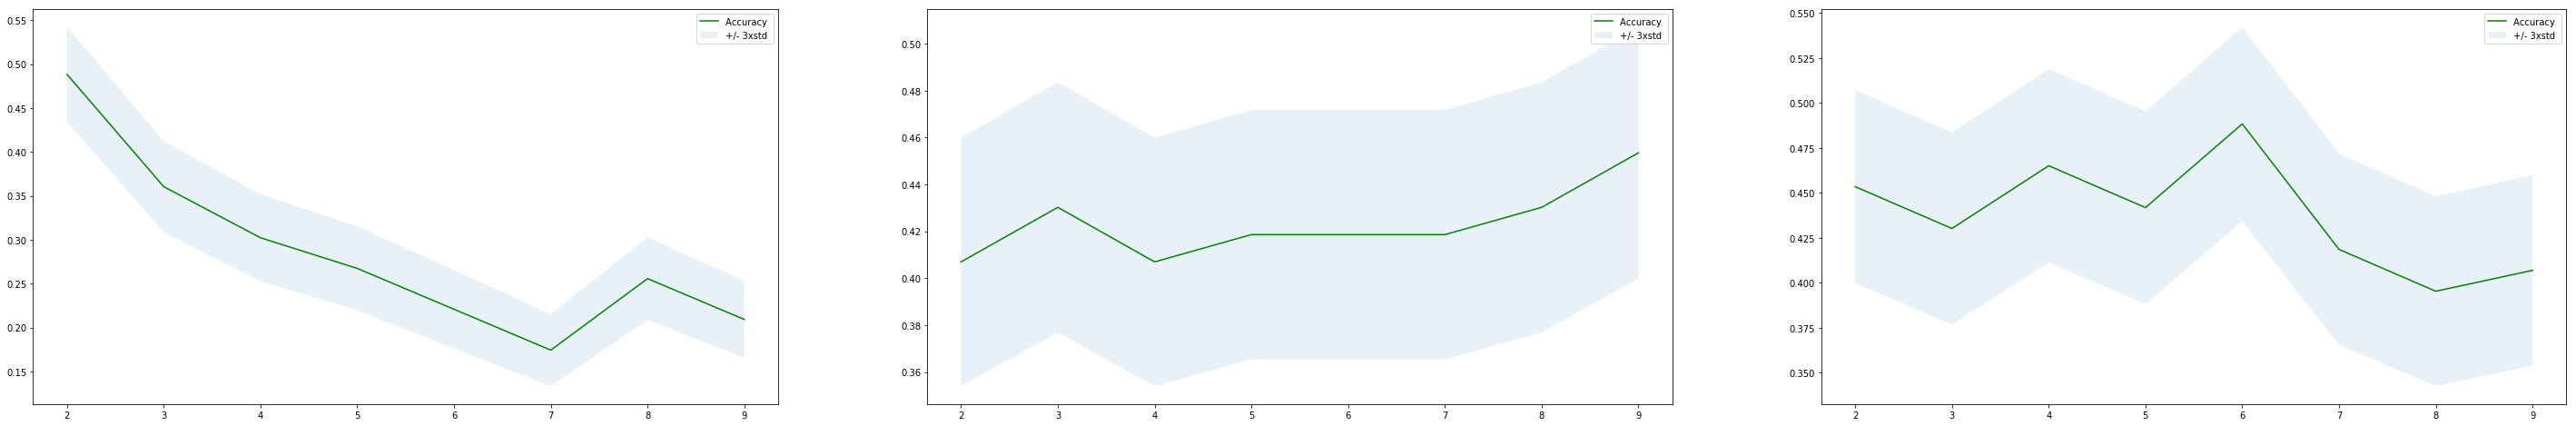

In [392]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics

#X=huntington_and_charleston_merged[['category_id','1st Most Common Venue']]
X=huntington_and_charleston_merged[['category_id']]
y=huntington_and_charleston_merged['city_id'].values

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

#find best k
Ks = 10
KsMin=2
classifiers=[
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'kmeans'},
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'kneighbors'},
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'decisiontree'},
]

for n in range(KsMin,Ks):
    classifierkm = KMeans(n_clusters=n, random_state=0).fit(X_train,y_train)
    yhat=classifierkm.predict(X_test)
    classifiers[0]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[0]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    classifierknn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=classifierknn.predict(X_test)
    classifiers[1]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[1]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    classifierdt = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat=classifierdt.predict(X_test)
    classifiers[2]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[2]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(50, 8))
axes[0].plot(range(KsMin,Ks),classifiers[0]['mean_acc'],'g')
axes[0].fill_between(range(KsMin,Ks),classifiers[0]['mean_acc'] - 1 * classifiers[0]['std_acc'],classifiers[0]['mean_acc'] + 1 * classifiers[0]['std_acc'], alpha=0.10)
axes[0].legend(('Accuracy ', '+/- 3xstd'))

axes[1].plot(range(KsMin,Ks),classifiers[1]['mean_acc'],'g')
axes[1].fill_between(range(KsMin,Ks),classifiers[1]['mean_acc'] - 1 * classifiers[1]['std_acc'],classifiers[1]['mean_acc'] + 1 * classifiers[1]['std_acc'], alpha=0.10)
axes[1].legend(('Accuracy ', '+/- 3xstd'))

axes[2].plot(range(KsMin,Ks),classifiers[2]['mean_acc'],'g')
axes[2].fill_between(range(KsMin,Ks),classifiers[2]['mean_acc'] - 1 * classifiers[2]['std_acc'],classifiers[2]['mean_acc'] + 1 * classifiers[2]['std_acc'], alpha=0.10)
axes[2].legend(('Accuracy ', '+/- 3xstd'))

print("The best accuracy for KMeans", classifiers[0]['mean_acc'].max(), "with k=", classifiers[0]['mean_acc'].argmax()+KsMin) 
print("The best accuracy for KNearestNeighbor", classifiers[1]['mean_acc'].max(), "with k=", classifiers[1]['mean_acc'].argmax()+KsMin) 
print("The best accuracy for DecisionTree", classifiers[2]['mean_acc'].max(), "with k=", classifiers[2]['mean_acc'].argmax()+KsMin) 

### Check logistic regression model results

In [402]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
metrics.accuracy_score(y_test, yhat)
#from sklearn.metrics import log_loss
#log_loss(y_test, yhat_prob)

0.45348837209302323

### Check support vector machine results

In [403]:
clf = svm.SVC(kernel='rbf').fit(X_train, y_train) 
yhat = clf.predict(X_test)
metrics.accuracy_score(y_test, yhat)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.3953488372093023

### DecisionTreeClassifier is the best model with an accuracy of 49% when max depth is 6. Here I get a distribution of the amount of times it recommended Huntington vs recommending Charleston <a name='datamodelingsel' />

In [404]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
#X2=huntington_and_charleston_merged[['category_id','1st Most Common Venue']]
X2=huntington_and_charleston_merged[['category_id']]
y2=huntington_and_charleston_merged['city_id'].values
classifier = DecisionTreeClassifier(criterion="entropy", max_depth = 6).fit(X2,y2)
ar=[]
#for idx,row in huntington_and_charleston_merged[['category_id','1st Most Common Venue']].iterrows():
for idx,row in huntington_and_charleston_merged[['category_id']].iterrows():
#    p=classifier.predict([row[['category_id','1st Most Common Venue']]])[0]
    p=classifier.predict([[row['category_id']]])[0]
    ar.append(p)

unique,counts=np.unique(ar, return_counts=True)
dict(zip(unique, counts))

{0: 192, 1: 92}